# Chapter 1. Projection images

In this section, we will start to look at the basic relation between an object, the Fourier transform of the object and an image of the object. The aim is to give you a general idea of what is going on, so don't worry if you don't understand every detail at this stage since we will study the details more closely in the following sections. The point of this tutorial is not to test your Python knowledge, so examples of most of the code that you need to write is given in the tutorial.

## 1.1 Setting the scene

You should be able to read the data for the caffeine molecule into Python with the command **caf = Molecule('caffeine.pdb')**. The class **Molecule** reads the **ATOM** fields of a standard PDB-file (caffeine.pdb in this case) and returns the data in a class object (which we named **caf** in this example). Once the object is created, you can access the coordinates of the atoms with the commands **caf.x**, **caf.y** and **caf.z**. The object contains several other fields, but you don't need to worry about those for the moment.

In [1]:
%%capture
# Suppress warning output when importing matplotlib.
%matplotlib inline
# To enable interactive figures in the IPython notebook: use '%matplotlib notebook' instead
# But this interactive mode has some display problems.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
plt.rcParams["figure.figsize"] = (8, 6)
from IPython.display import HTML

In [2]:
# add path to the Modules
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

In [3]:
# All functions required for Chapter 1 is contained in Projection.py
from Projection import *

In [4]:
# Read the pdb file for caffeine molecule.
caf = Molecule('caffeine.pdb')

In [5]:
print "name: ", caf.name
print "elements: ", caf.element
print "pos x: ", caf.x
print "pos y: ", caf.y
print "pos z: ", caf.z
print "coordinate[1,3]: ", caf.crd[1][3]
print "IDP: ", caf.IDP

name:  ['N1', 'C2', 'C3', 'C4', 'C5', 'N6', 'N7', 'N8', 'C9', 'C10', 'C11', 'C12', 'O13', 'O14']
elements:  ['N', 'C', 'C', 'C', 'C', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'O', 'O']
pos x:  [0.011, 1.357, -0.187, 1.08, -1.022, 2.046, 1.284, -1.086, 2.643, -2.249, -1.381, 0.193, -2.541, 0.335]
pos y:  [2.295, 2.47, 0.922, 0.375, 3.323, 1.332, -0.985, -1.253, -1.525, -2.148, 0.13, -1.854, 0.535, -3.069]
pos z:  [0.021, 0.025, -0.005, -0.004, -0.034, 0.015, -0.012, -0.008, -0.004, 0.001, 0.015, -0.012, 0.05, -0.015]
coordinate[1,3]:  0.375
IDP:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Use the function **drawmol(caf,elevation,azimuth)** to display a graphical space-filling model of the caffeine molecule, where **elevation** and **azimuth** set the direction of view. The units of the axes are $\overset{\circ}{\text{A}}$. <span style="color:blue">Approximately how large is the molecule?</span>

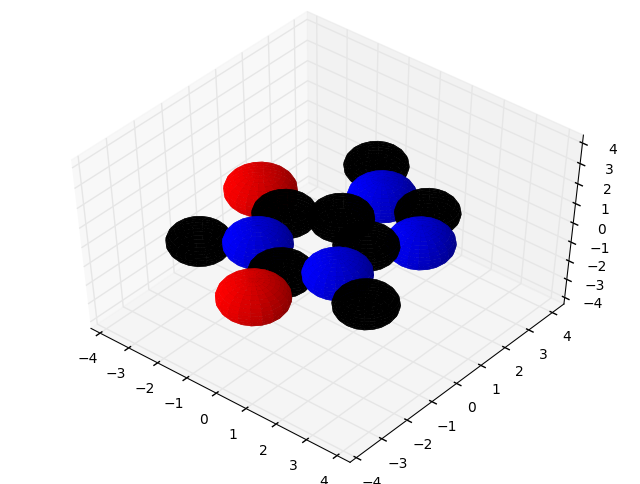

In [6]:
drawmol(caf, 50, -50) # set a good angle for viewing

## 1.2 Your first projection

By a projection of a function we mean an integral of the function along a single coordinate,

$$
P_z(x, y) = \int_{-\infty}^{\infty} \rho(x,y,z)\text{d}z
$$

Formally, this is called a Radon transform. Such a projection essentially squeezes the function flat along one coordinate axis (the z-axis in the above equation). Since the caffeine molecule is already practically flat in the xy-plane, a projection along the z-axis does not look much different from the original viewed from the top.

A tomogram, such as an electron microscopy image, an X-ray tomogram or an ultrasound image, is to a very good approximation a projection of an object. The beauty of projections, from our point of view, is that they have a very simple interpretation in Fourier space: **The Fourier transform of a projection is a plane passing through the origin of the Fourier transform of the projected object.** This is often called the Fourier-slice theorem or the projection theorem, and it is the basis of all types of tomography.

We will refer to the Fourier transform of a molecule's electron density as the *molecular transform*. The space of the molecular transform may be called Fourier space, frequency space, reciprocal space or diffraction space. The space of the electron density is simply called real space. The two spaces work pretty much the same (they are both Euclidean). Notationally we will distinguish Fourier space from real space by renaming the coordinate triple $xyz$ to $hkl$. A projection of the electron density along the $z$-axis (as in the above equation) then corresponds to the $hk$-plane of the molecular transform.

Using Python, construct a set of points in the $hk$-plane. Let this example be your guideline (later on we will use the function **TwoD_grid(step, cutoff)** to generate this 2D grid):

In [7]:
# Distance between samples
step = 1/8.
cutoff = 5

# Sample points on positive h-axis
h = np.arange(0, cutoff, step) + step
# Add sample points on negative axis and at the origin
h = np.concatenate((h[::-1], np.zeros(1), -h),axis=0)

# Use the same points for the k-axis
k = h

In [8]:
# Construct a two-dimensional grid
[H,K] = np.meshgrid(h,k)
L = np.zeros_like(K)

Use the above settings for step length and cutoff for now (we will look at the effect of different settings later). You can view the plane with the command

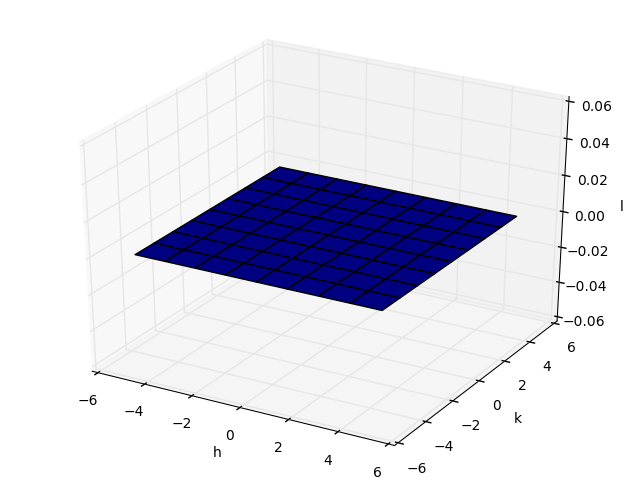

In [9]:
ax = plt.figure().gca(projection='3d')
# Plot the surface.
surf = ax.plot_surface(H, K, L)
ax.set_xlabel('h')
ax.set_ylabel('k')
ax.set_zlabel('l')

Then evaluate the molecular transform of the caffeine molecule on the plane using the function **moltrans**

In [10]:
F = moltrans(caf, H,K,L)

Given a molecule struct, **moltrans** calculates the Fourier transform of the molecule's electron density at the points $H$, $K$ and $L$. The reason that we cannot use Python's built-in Fourier transform is that we don't explicitly know the electron density; the PDB-file only contains the information about the atom types and positions. **moltrans** is able to work directly with data from a PDB-file.

By the Fourier-slice theorem, the data $F$ corresponds to the *Fourier transform of a projection of the caffeine molecule along the z-axis*. We can easily verify this by inverse transforming the data. Python provides the functions **fft**, **fft2** and **fftn** for the Fourier transform. We will use **ifftn** which performs an n-dimensional inverse discrete Fourier transform

In [11]:
rho = fft.fftshift(abs(fft.ifftn(F, [2**10, 2**10])))

You don't need to fully grasp the details of that function call yet, but here's a short explanation: $F$ is the function we transform. The vector [$2^{10}$,$2^{10}$] essentially tells **ifftn** how many sample points in each dimension it should evaluate the transform on (try remove this argument and compare the result). We use **ifftn** which differs from **fftn** by a minus sign in the exponential and a scale factor. We could use **fftn**, but then the result would be scaled and inverted with respect to the original, just like in a real imaging system. We take the absolute value, because the result may have a small imaginary part due to numerical instabilities (actually, it may have quite a large imaginary part, but it is a purely computational side-effect which is correctly compensated for if the absolute value is taken). Finally, we need the function **fftshift** because the "normal" behavior of the **FFT** is to put the center point in the upper left corner and the upper left corner in the center.

Now view the output of the Fourier transform (i.e. **rho**) using **imshow**. If you use the code below, you should get the right units on the axis.

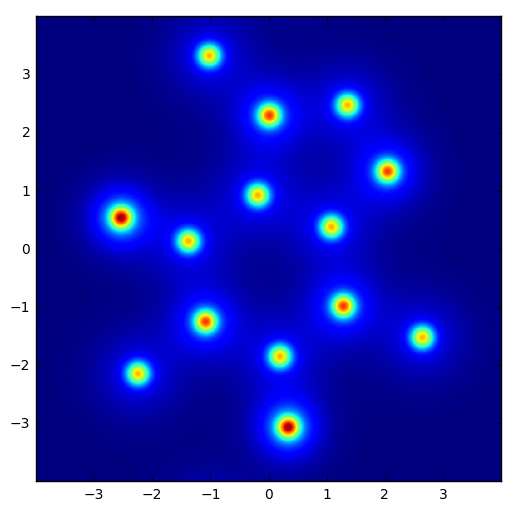

In [12]:
# Create vectors for the x and y coordinates.
size = rho.shape
x = np.linspace(0,1-1./size[1],size[1])/step
y = np.linspace(0,1-1./size[0],size[0])/step
x = x - np.mean(x)
y = y - np.mean(y)

# Draw the image
plt.imshow(rho, interpolation='none',origin='lower', extent = [x[0], x[-1], y[0], y[-1]])

<span style="color:blue">Does this seem like a reasonable projection of the caffeine molecule?</span> You can compare to a two-dimensional plot of the form **plot(caf.x,caf.y, 'o')**. <span style="color:blue">In what sense is a two dimensional plot of a three-dimensional function similar to a projection?</span>

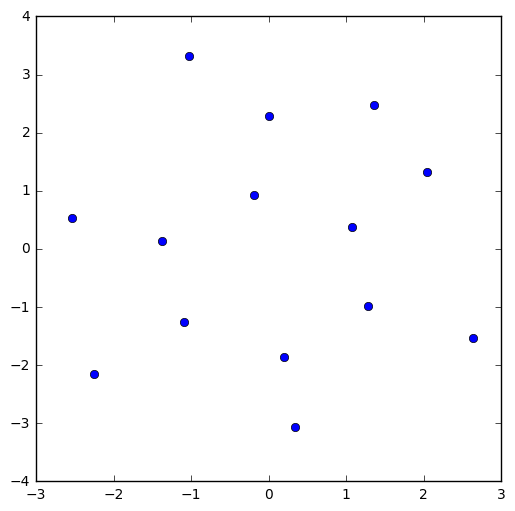

In [13]:
plt.figure(figsize = (6,6))
plt.plot(caf.x, caf.y, 'o')

Also, in the projection image you will see a few spots that shine more brightly than the rest. <span style="color:blue">Can you explain this?</span> In fact, there are three different levels of brightness of the spots, although the intermediate ones may be hard to distinguish from the low-intensity spots. For clues, look again at the space-fill model with **drawmol(caf,elevation,azimuth)**. Set the view so that you look straight at the $xy$-plane. You can also view the contour curves of the projected electron density using **contour(x,y,rho)**. Zoom in on different atoms to see more clearly.

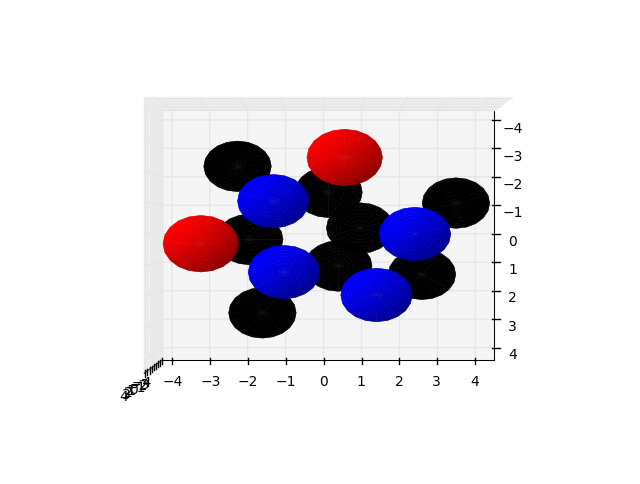

In [14]:
drawmol(caf, 90, 0)

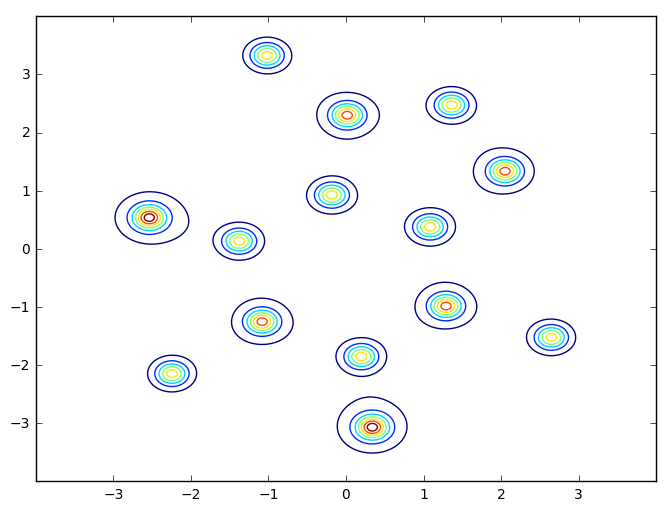

In [15]:
plt.contour(x, y, rho)

Let's return for a bit to the section of the molecular transform that we created with **moltrans**. The molecular transform $F$ is a complex function which we cannot measure directly (if you look at your matrix $F$ you will see that all entries but one are complex). We can attempt to measure the molecular transform in a diffraction experiment, but what we actually will record is the intensity of the transform, i.e., the square of its amplitude. To measure the intensity of the section of the molecular transform that you created earlier, we would direct radiation along the $z$-axis of the molecule. We would also have to use radiation with an extremely short wavelength. X-rays would be too long, but more about this later in the section about the Ewald sphere.

Calculate and visualize the intensity of your matrix $F$ with the commands

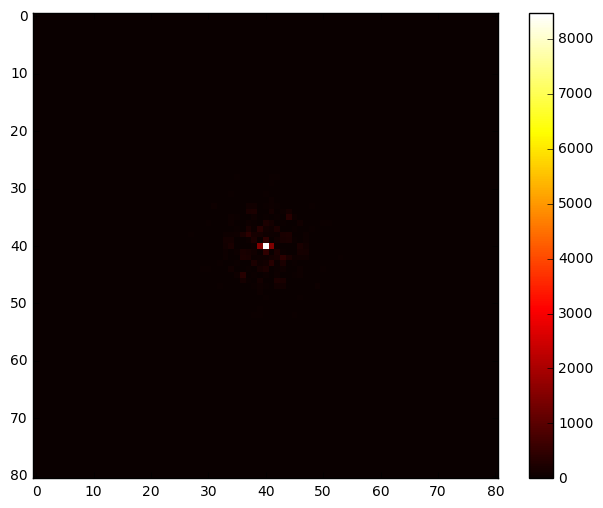

In [16]:
ints = abs(F)**2
plt.imshow(ints, interpolation='none', cmap = 'hot')
plt.colorbar()

As you see, the image is mostly dark. This is because the central pixel is so intense in comparison to the rest. You can perhaps see this more clearly with a 3D plot. 

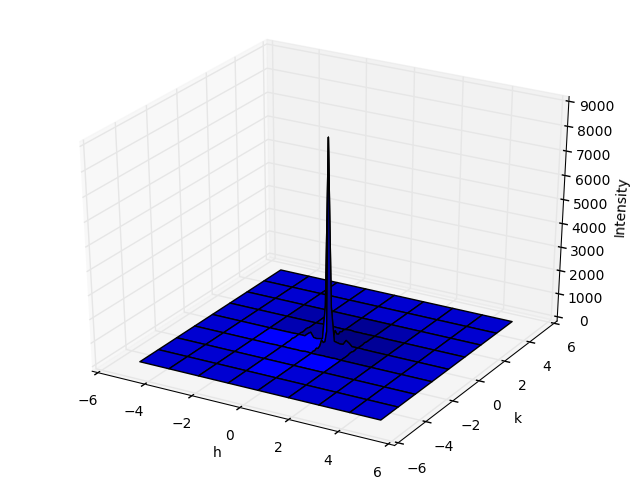

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')
# Plot the surface.
surf = ax.plot_surface(H, K, ints)
ax.set_xlabel('h')
ax.set_ylabel('k')
ax.set_zlabel('Intensity')

A work-around is to plot the logarithm of the intensities:

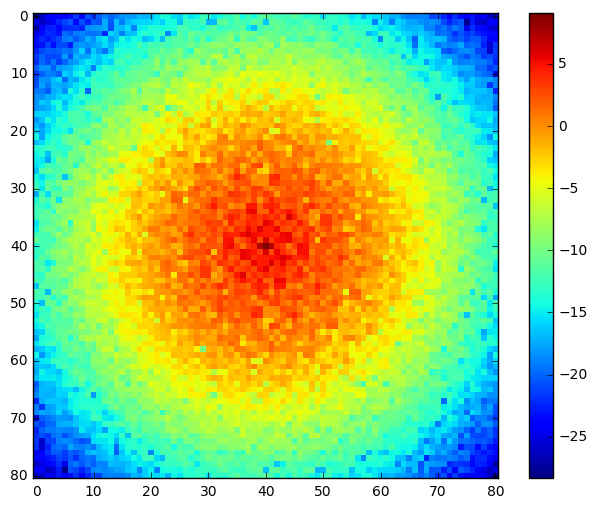

In [18]:
plt.imshow(np.log(ints), interpolation='none')
plt.colorbar()

You can also see that the diffraction pattern is sampled quite coarsely. Increasing the sampling density may yield a prettier picture, but it would not provide more information about the structure (we may look more closely at this later; it is explained by the sampling theorem for bandlimited functions).

## 1.3 Your first movie

It is now time to generate a number of different projections and see if they can give us any clue to the three-dimensional structure of caffeine. Many projections correspond to many planes through the origin of Fourier space, so the first task should be to generate a set of such planes. We suggest that you do this by rotating the plane that you generated previously around a fixed axis (say the $h$-axis). You will need a rotation matrix, and that is given to you by the function **rotationmatrix(phi,n)**. Here **phi** is the rotation angle and **n** is a vector along the rotation axis. The corresponding rotation will be counterclockwise when viewed from the tip of the vector.

Essentially, what you need to do is the following. Generate a reasonable number of evenly distributed angles, for example with **linspace**,

In [19]:
nViews = 20
phi = np.linspace(0,2*np.pi,nViews+1)

Also, put the coordinates original $hk$-plane into one big $N \times 3$ matrix that can be multiplied by the rotation matrix. Construct a new set of matrices to store the rotated planes in (otherwise you will overwrite your original plane).

In [20]:
N = H.shape[0] * H.shape[1]
Hrot = np.reshape(H, N)
Krot = np.reshape(K, N)
Lrot = np.reshape(L, N)
HKLrot = np.array([Hrot, Krot, Lrot])
HKL = HKLrot

Then make a for-loop and within which you sequentially do the following:
- rotate the plane through Fourier space around the $h$-axis
- calculate the molecular transform
- calculate the projection
- display the intensity of the transform (the diffraction pattern)
- display the projection

In [21]:
%%capture
fig, (ax1, ax2) = plt.subplots(1,2)
ims = []

for iViews in range(nViews):
    R = rotationmatrix(phi[iViews], [1,0,0])
    HKLrot = np.dot(R, HKL)
    Hrot = np.reshape(HKLrot[0, :], H.shape)
    Krot = np.reshape(HKLrot[1, :], K.shape)
    Lrot = np.reshape(HKLrot[2, :], L.shape)
    F = moltrans(caf, Hrot, Krot, Lrot)
    rho = fft.fftshift(abs(fft.ifftn(F, [2**10,2**10])))
    im1 = ax1.imshow(np.real(np.log(abs(F)**2)), interpolation='none',origin='lower', animated=True)
    im2 = ax2.imshow(np.real(rho), interpolation='none',origin='lower', animated=True)
    ims.append([im1, im2])

ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000)

In [22]:
HTML(ani.to_html5_video())

You can play with the settings of the movie, like the **interval** and **nViews**, to control the number of frames as well as the speed of playing.

## 1.4 Test

By typing load patterns you will load the variable patterns into Matlab. This variable contains 20 diffraction patterns from one of either lysozyme, valium, nicotine or ethanol (in this case the pattterns are planar sections of the molecular transform, including phases). Can you identify the molecule by applying the techniques that you have used in the tutorial so far? You can access the i:th pattern by typing patterns{i} (note the curly braces). You load the molecular structures into Matlab with e.g. lys = pdbreadatom('lysozyme.pdb').